# Model Analisis Sentimen Ulasan Aplikasi Microsoft Office

## Import Library yang Dibutuhkan

Mengimpor semua library yang diperlukan untuk proses data dan analisis sentimen.

In [1]:
!pip install PySastrawi tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 4.5 MB/s eta 0:00:00


In [41]:
# Import libraries
import pandas as pd
import numpy as np
import re
import string
import requests
import csv
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Add, Activation, Dropout, Embedding, LSTM, Bidirectional, BatchNormalization, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

from io import StringIO

from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Load Dataset

Membaca dataset langsung dari URL yang disediakan dan menampilkan beberapa baris awal serta informasi dasar tentang dataset.

In [16]:
dataset_path = 'app_reviews.csv'
dataset = pd.read_csv(dataset_path)

# Menampilkan 5 data pertama
dataset.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,8fd8e430-87d1-496e-9a39-c92e27c0465b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Belakangan tidak bisa membuka pdf yg memorinya...,3,1,16.0.18129.20078,2024-10-28 07:49:41,NaN,NaN,16.0.18129.20078
1,233d48cd-062b-424b-8155-bb084a700175,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Membantu bekerja, terima kasih. Setelah pemaka...",5,127,16.0.17928.20046,2024-09-05 00:50:04,NaN,NaN,16.0.17928.20046
2,5d43878f-9f7f-4ddb-bc89-611ce73793f2,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Saya membayar Office 365 basic disebutkan bisa...,1,3,16.0.18025.20078,2024-10-02 02:25:31,NaN,NaN,16.0.18025.20078
3,3b06d368-f2e7-4e9e-a27f-09dbd533c88f,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Kok font times new roman di hapus padahal nih ...,1,6,16.0.18025.20114,2024-10-06 23:21:35,NaN,NaN,16.0.18025.20114
4,c52d5bfc-db29-4651-bc92-a6d68f995d52,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Fitur bagus, tapi kekurangan tidak bisa buka d...",3,4,16.0.18025.20078,2024-10-02 12:51:55,NaN,NaN,16.0.18025.20078


## Data Preprocessing
Memproses data sebelum dianalisis

### Data Cleaning
Menghapus data kosong, duplikat, dan mereset indeks

In [17]:
dataset_clean = dataset.dropna(subset=['content'])
dataset_clean = dataset_clean.drop_duplicates()
dataset_clean.reset_index(drop=True, inplace=True)
dataset_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              20000 non-null  object
 1   userName              20000 non-null  object
 2   userImage             20000 non-null  object
 3   content               20000 non-null  object
 4   score                 20000 non-null  int64 
 5   thumbsUpCount         20000 non-null  int64 
 6   reviewCreatedVersion  16838 non-null  object
 7   at                    20000 non-null  object
 8   replyContent          31 non-null     object
 9   repliedAt             31 non-null     object
 10  appVersion            16838 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.7+ MB


### Data Cleaning

Melakukan beberapa langkah pembersihan teks, termasuk penghapusan URL, tanda baca, angka, dan stopwords. Selain itu, juga menggunakan stemming untuk mengurangi kata ke bentuk dasarnya.

In [18]:
# Inisialisasi Stemmer dan StopWord Remover dari PySastrawi
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

stopword_factory = StopWordRemoverFactory()
stopword_remover = stopword_factory.create_stop_word_remover()

# Kamus slang words
slang_dict = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"}

def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'\d', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.replace('\n', ' ')  # Replace newlines with space
    text = text.strip()  # Remove leading and trailing spaces
    return text

def lowercase_text(text):
    return text.lower()

def replace_slang(text):
    words = word_tokenize(text)
    words = [slang_dict.get(word, word) for word in words]
    return ' '.join(words)

def remove_stopwords(text):
    return stopword_remover.remove(text)

def perform_stemming(text):
    return stemmer.stem(text)

def preprocess_text(text):
    text = clean_text(text)
    text = lowercase_text(text)
    text = replace_slang(text)
    text = remove_stopwords(text)
    text = perform_stemming(text)
    return text


In [19]:
slangwords = {
    "@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual",
    "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong",
    "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada",
    "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber",
    "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know",
    "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya",
    "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak",
    "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing",
    "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial",
    "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi",
    "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu",
    "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya",
    "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan",
    "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi",
    "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda",
    "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan",
    "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga",
    "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang",
    "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana",
    "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya",
    "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum",
    "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah",
    "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga",
    "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng",
    "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan",
    "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia",
    "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa",
    "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar",
    "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi",
    "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal",
    "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat",
    "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja",
    "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih",
    "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong",
    "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi",
    "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek",
    "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall",
    "cups": "culun", "curanmor": "pencurian kendaraan bermotor",
    "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta",
    "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik",
    "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan",
    "diancurin": "dihancurkan", "dimaafin": "dimaafkan",
    "dimintak": "diminta", "disono": "di sana", "dket": "dekat",
    "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu",
    "dngn": "dengan", "dodol": "bodoh", "doku": "uang",
    "dongs": "dong", "dpt": "dapat", "dri": "dari",
    "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya",
    "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi",
    "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu",
    "emangnya": "memangnya", "emng": "memang", "endak": "tidak",
    "enggak": "tidak", "envy": "iri", "ex": "mantan",
    "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back",
    "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak",
    "gaje": "tidak jelas", "gak papa": "tidak apa-apa",
    "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi",
    "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka",
    "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis",
    "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana",
    "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas",
    "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh",
    "golput": "golongan putih", "gowes": "mengayuh sepeda",
    "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan",
    "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok",
    "gw": "saya", "ha": "tertawa", "haha": "tertawa",
    "hallow": "halo", "hankam": "pertahanan dan keamanan",
    "hehe": "he", "helo": "halo", "hey": "hai",
    "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong",
    "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat",
    "huff": "mengeluh", "hum": "rumah", "humz": "rumah",
    "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion",
    "imoetz": "imut", "item": "hitam", "itungan": "hitungan",
    "iye": "iya", "ja": "saja", "jadiin": "jadi",
    "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi",
    "jem": "jam", "jga": "juga", "jgnkan": "jangankan",
    "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar",
    "jubir": "juru bicara", "jutek": "galak", "k": "ke",
    "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau",
    "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau",
    "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat",
    "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena",
    "kasubbag": "kepala subbagian", "katrok": "kampungan",
    "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus",
    "kec": "kecamatan", "kejurnas": "kejuaraan nasional",
    "kekeuh": "keras kepala", "kel": "kelurahan",
    "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau",
    "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa",
    "kesra": "kesejahteraan rakyat", "ketrima": "diterima",
    "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin",
    "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang",
    "klw": "kalau", "km": "kamu", "kmps": "kampus",
    "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa",
    "kodya": "kota madya", "komdis": "komisi disiplin",
    "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman",
    "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan",
    "krenz": "keren", "krm": "kirim", "kt": "kita",
    "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan",
    "kw": "imitasi", "kyk": "seperti", "la": "lah",
    "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara",
    "latgab": "latihan gabungan", "lebay": "berlebihan",
    "leh": "boleh", "lelet": "lambat", "lemot": "lambat",
    "lgi": "lagi", "lgsg": "langsung", "liat": "lihat",
    "litbang": "penelitian dan pengembangan", "lmyn": "lumayan",
    "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir",
    "louph": "cinta", "low": "kalau", "lp": "lupa",
    "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu",
    "lum": "belum", "luthu": "lucu", "lwn": "lawan",
    "maacih": "terima kasih", "mabal": "bolos", "macem": "macam",
    "macih": "masih", "maem": "makan", "magabut": "makan gaji buta",
    "maho": "homo", "mak jang": "kaget", "maksain": "memaksa",
    "malem": "malam", "mam": "makan", "maneh": "kamu",
    "maniez": "manis", "mao": "mau", "masukin": "masukkan",
    "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu",
    "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol",
    "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin",
    "mo": "mau", "mokad": "mati", "moso": "masa",
    "mpe": "sampai", "msk": "masuk", "mslh": "masalah",
    "mt": "makan teman", "mubes": "musyawarah besar",
    "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional",
    "muntaber": "muntah dan berak", "musti": "mesti",
    "muupz": "maaf", "mw": "now watching", "n": "dan",
    "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa",
    "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif",
    "narkoba": "narkotika, psikotropika, dan obat terlarang",
    "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri",
    "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta",
    "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku",
    "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan",
    "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan",
    "ngebandel": "berbuat bandel", "ngegosip": "bergosip",
    "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis",
    "ngeles": "berkilah", "ngelidur": "menggigau",
    "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong",
    "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan",
    "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari",
    "ngurus": "mengurus", "nie": "ini", "nih": "ini",
    "niyh": "nih", "nmr": "nomor", "nntn": "nonton",
    "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti",
    "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi",
    "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil",
    "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau",
    "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic",
    "org2": "orang-orang", "ortu": "orang tua",
    "otda": "otonomi daerah", "otw": "on the way, sedang di jalan",
    "pacal": "pacar", "pake": "pakai", "pala": "kepala",
    "pansus": "panitia khusus", "parpol": "partai politik",
    "pasutri": "pasangan suami istri", "pd": "pada",
    "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional",
    "pemda": "pemerintah daerah", "pemkot": "pemerintah kota",
    "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani",
    "perda": "peraturan daerah", "perhatiin": "perhatikan",
    "pesenan": "pesanan", "pgang": "pegang",
    "pi": "tapi", "pilkada": "pemilihan kepala daerah",
    "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling",
    "pmrnth": "pemerintah", "polantas": "polisi lalu lintas",
    "ponpes": "pondok pesantren", "pp": "pulang pergi",
    "prg": "pergi", "prnh": "pernah", "psen": "pesan",
    "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman",
    "qmu": "kamu", "rakor": "rapat koordinasi",
    "ranmor": "kendaraan bermotor", "re": "reply",
    "ref": "referensi", "rehab": "rehabilitasi",
    "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika",
    "rhs": "rahasia", "rmh": "rumah", "ru": "baru",
    "ruko": "rumah toko", "rusunawa": "rumah susun sewa",
    "ruz": "terus", "saia": "saya", "salting": "salah tingkah",
    "sampe": "sampai", "samsek": "sama sekali",
    "sapose": "siapa", "satpam": "satuan pengamanan",
    "sbb": "sebagai berikut", "sbh": "sebuah",
    "sbnrny": "sebenarnya", "scr": "secara",
    "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju",
    "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok",
    "sempet": "sempat", "sendratari": "seni drama tari",
    "sgt": "sangat", "shg": "sehingga", "siech": "sih",
    "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik",
    "siramin": "siramkan", "sj": "saja", "skalian": "sekalian",
    "sklh": "sekolah", "skt": "sakit", "slesai": "selesai",
    "sll": "selalu", "slma": "selama", "slsai": "selesai",
    "smpt": "sempat", "smw": "semua", "sndiri": "sendiri",
    "soljum": "sholat jumat", "songong": "sombong",
    "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu",
    "spa": "siapa", "sppa": "siapa", "spt": "seperti",
    "srtfkt": "sertifikat", "stiap": "setiap",
    "stlh": "setelah", "suk": "masuk", "sumpek": "sempit",
    "syg": "sayang", "t4": "tempat", "tajir": "kaya",
    "tau": "tahu", "taw": "tahu", "td": "tadi",
    "tdk": "tidak", "teh": "kakak perempuan",
    "telat": "terlambat", "telmi": "telat berpikir",
    "temen": "teman", "tengil": "menyebalkan",
    "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu",
    "thankz": "terima kasih", "thn": "tahun",
    "tilang": "bukti pelanggaran", "tipiwan": "TvOne",
    "tks": "terima kasih", "tlp": "telepon",
    "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman",
    "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu",
    "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada",
    "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih",
    "trm": "terima", "trs": "terus", "trutama": "terutama",
    "ts": "penulis", "tst": "tahu sama tahu",
    "ttg": "tentang", "tuch": "tuh", "tuir": "tua",
    "tw": "tahu", "u": "kamu", "ud": "sudah",
    "udah": "sudah", "ujg": "ujung", "ul": "ulangan",
    "unyu": "lucu", "uplot": "unggah", "urang": "saya",
    "usah": "perlu", "utk": "untuk", "valas": "valuta asing",
    "w/": "dengan", "wadir": "wakil direktur",
    "wamil": "wajib militer", "warkop": "warung kopi",
    "warteg": "warung tegal", "wat": "buat",
    "wkt": "waktu", "wtf": "what the fuck",
    "xixixi": "tertawa", "ya": "iya", "yap": "iya",
    "yaudah": "ya sudah", "yawdah": "ya sudah",
    "yg": "yang", "yl": "yang lain", "yo": "iya",
    "yowes": "ya sudah", "yup": "iya", "7an": "tujuan",
    "ababil": "abg labil", "acc": "accord", "adlah": "adalah",
    "adoh": "aduh", "aha": "tertawa", "aing": "saya",
    "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai",
    "akko": "aku", "akku": "aku", "akyu": "aku",
    "aljasa": "asal jadi saja", "ama": "sama",
    "ambl": "ambil", "anjir": "anjing", "ank": "anak",
    "ap": "apa", "apaan": "apa", "ape": "apa",
    "aplot": "unggah", "apva": "apa", "aqu": "aku",
    "asap": "sesegera mungkin", "aseek": "asyik",
    "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik",
    "astrojim": "astagfirullahaladzim", "ath": "kalau begitu",
    "atuh": "kalau begitu", "ava": "avatar", "aws": "awas",
    "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara",
    "bales": "balas", "bangdes": "pembangunan desa",
    "bangkotan": "tua", "banpres": "bantuan presiden",
    "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah",
    "bcoz": "karena", "beb": "sayang", "bejibun": "banyak",
    "belom": "belum", "bener": "benar", "ber2": "berdua",
    "berdikari": "berdiri di atas kaki sendiri", "bet": "banget",
    "beti": "beda tipis", "beut": "banget", "bgd": "banget",
    "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan",
    "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli",
    "blg": "bilang", "blm": "belum", "bls": "balas",
    "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak",
    "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar",
    "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu",
    "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat",
    "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa",
    "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan",
    "buber": "buka bersama", "bujubune": "luar biasa",
    "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar",
    "byr": "bayar", "c8": "chat", "cabut": "pergi",
    "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam",
    "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang",
    "cekidot": "coba lihat", "cemplungin": "cemplungkan",
    "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek",
    "cibuk": "sibuk", "cin": "cinta", "ciye": "cie",
    "ckck": "ck", "clbk": "cinta lama bersemi kembali",
    "cmpr": "campur", "cnenk": "senang", "congor": "mulut",
    "cow": "cowok", "coz": "karena", "cpa": "siapa",
    "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama",
    "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu",
    "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman",
    "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa",
    "handak": "bahan peledak", "hansip": "pertahanan sipil",
    "hellow": "halo", "helow": "halo", "hi": "hai",
    "hlng": "hilang", "hnya": "hanya", "houm": "rumah",
    "hrs": "harus", "hubad": "hubungan angkatan darat",
    "hubla": "perhubungan laut", "huft": "mengeluh",
    "humas": "hubungan masyarakat", "idk": "saya tidak tahu",
    "ilfeel": "tidak suka", "imba": "jago sekali",
    "imoet": "imut", "info": "informasi", "itung": "hitung",
    "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya",
    "jablay": "jarang dibelai", "jadul": "jaman dulu",
    "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan",
    "jg": "juga", "jgn": "jangan", "jijay": "jijik",
    "jkt": "jakarta", "jnj": "janji", "jth": "jatuh",
    "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak",
    "kabag": "kepala bagian", "kacian": "kasihan",
    "kadit": "kepala direktorat", "kaga": "tidak",
    "kaka": "kakak", "kamtib": "keamanan dan ketertiban",
    "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten",
    "kasat": "kepala satuan", "kasubbid": "kepala subbidang",
    "kau": "kamu", "kbar": "kabar", "kcian": "kasihan",
    "keburu": "terlanjur", "kedubes": "kedutaan besar",
    "kek": "seperti", "keknya": "kayaknya",
    "keliatan": "kelihatan", "keneh": "masih",
    "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang",
    "kere": "tidak punya uang", "kesian": "kasihan",
    "ketauan": "ketahuan", "keukeuh": "keras kepala",
    "khan": "kan", "kibus": "kaki busuk", "kk": "kakak",
    "klian": "kalian", "klo": "kalau", "kluarga": "keluarga",
    "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus",
    "kn": "kan", "knl": "kenal", "knpa": "kenapa",
    "kog": "kok", "kompi": "komputer",
    "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal",
    "koq": "kok", "kpd": "kepada", "kptsan": "keputusan",
    "krik": "garing", "krn": "karena", "ktauan": "ketahuan",
    "ktny": "katanya", "kudu": "harus", "kuq": "kok",
    "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan",
    "lambreta": "lambat", "lansia": "lanjut usia",
    "lapas": "lembaga pemasyarakatan", "lbur": "libur",
    "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap",
    "lht": "lihat", "linmas": "perlindungan masyarakat",
    "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh",
    "lol": "tertawa", "lom": "belum", "loupz": "cinta",
    "lowh": "kamu", "lu": "kamu", "luchu": "lucu",
    "luff": "cinta", "luph": "cinta", "lw": "kamu",
    "lwt": "lewat", "maaciw": "terima kasih",
    "mabes": "markas besar", "macem-macem": "macam-macam",
    "madesu": "masa depan suram", "maen": "main",
    "mahatma": "maju sehat bersama", "mak": "ibu",
    "makasih": "terima kasih", "malah": "bahkan",
    "malu2in": "memalukan", "mamz": "makan",
    "manies": "manis", "mantep": "mantap",
    "markus": "makelar kasus", "mba": "mbak",
    "mending": "lebih baik", "mgkn": "mungkin",
    "mhn": "mohon", "miker": "minuman keras",
    "milis": "mailing list", "mksd": "maksud",
    "mls": "malas", "mnt": "minta", "moge": "motor gede",
    "mokat": "mati", "mosok": "masa", "msh": "masih",
    "mskpn": "meskipun", "msng2": "masing-masing",
    "muahal": "mahal", "muker": "musyawarah kerja",
    "mumet": "pusing", "muna": "munafik",
    "munaslub": "musyawarah nasional luar biasa",
    "musda": "musyawarah daerah", "muup": "maaf",
    "muuv": "maaf", "nal": "kenal", "nangis": "menangis",
    "naon": "apa", "napol": "narapidana politik",
    "naq": "anak", "narsis": "bangga pada diri sendiri",
    "nax": "anak", "ndak": "tidak", "ndut": "gendut",
    "nekolim": "neokolonialisme", "nelfon": "menelepon",
    "ngabis2in": "menghabiskan", "ngakak": "tertawa",
    "ngambek": "marah", "ngampus": "pergi ke kampus",
    "ngantri": "mengantri", "ngapain": "sedang apa",
    "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan",
    "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar",
    "ngekos": "tinggal di kos", "ngelamar": "melamar",
    "ngeliat": "melihat", "ngemeng": "bicara terus-terusan",
    "ngerti": "mengerti", "nggak": "tidak",
    "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi",
    "ngmg": "bicara", "ngocol": "lucu",
    "ngomongin": "membicarakan", "ngumpul": "berkumpul",
    "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari",
    "nyiapin": "mempersiapkan", "nyiram": "menyiram",
    "nyok": "ayo", "o/": "oleh", "ok": "ok",
    "priksa": "periksa", "pro": "profesional", "psn": "pesan",
    "psti": "pasti", "puanas": "panas", "qmo": "kamu",
    "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin",
    "red": "redaksi", "reg": "register", "rejeki": "rezeki",
    "renstra": "rencana strategis", "reskrim": "reserse kriminal",
    "sni": "sini", "somse": "sombong sekali", "sorry": "maaf",
    "sosbud": "sosial-budaya", "sospol": "sosial-politik",
    "sowry": "maaf", "spd": "sepeda", "sprti": "seperti",
    "spy": "supaya", "stelah": "setelah", "subbag": "subbagian",
    "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa",
    "tabanas": "tabungan pembangunan nasional", "tar": "nanti",
    "taun": "tahun", "tawh": "tahu", "tdi": "tadi",
    "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi",
    "telp": "telepon", "temen2": "teman-teman",
    "tengok": "menjenguk", "terbitin": "terbitkan",
    "tgl": "tanggal", "thanks": "terima kasih",
    "thd": "terhadap", "thx": "terima kasih",
    "tipi": "TV", "tkg": "tukang", "tll": "terlalu",
    "tlpn": "telepon", "tman": "teman", "tmbh": "tambah",
    "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda",
    "tnh": "tanah", "togel": "toto gelap", "tp": "tapi",
    "tq": "terima kasih", "trgntg": "tergantung",
    "trims": "terima kasih", "cb": "coba", "y": "ya",
    "munfik": "munafik", "reklamuk": "reklamasi",
    "sma": "sama", "tren": "trend", "ngehe": "kesal",
    "mz": "mas", "analisise": "analisis", "sadaar": "sadar",
    "sept": "september", "nmenarik": "menarik",
    "zonk": "bodoh", "rights": "benar", "simiskin": "miskin",
    "ngumpet": "sembunyi", "hardcore": "keras",
    "akhirx": "akhirnya", "solve": "solusi",
    "watuk": "batuk", "ngebully": "intimidasi",
    "masy": "masyarakat", "still": "masih", "tauk": "tahu",
    "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama",
    "kentot": "senggama", "faktakta": "fakta", "sohib": "teman",
    "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela",
    "heters": "pembenci", "nyembah": "sembah",
    "most": "paling", "ikon": "lambang", "light": "terang",
    "pndukung": "pendukung", "setting": "atur",
    "seting": "akting", "next": "lanjut",
    "waspadalah": "waspada", "gantengsaya": "ganteng",
    "parte": "partai", "nyerang": "serang",
    "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani",
    "buangbuang": "buang", "tsangka": "tersangka",
    "kurng": "kurang", "ista": "nista", "less": "kurang",
    "koar": "teriak", "paranoid": "takut",
    "problem": "masalah", "tahi": "kotoran",
    "tirani": "tiran", "tilep": "tilap", "happy": "bahagia",
    "tak": "tidak", "penertiban": "tertib",
    "uasai": "kuasa", "mnolak": "tolak",
    "trending": "trend", "taik": "tahi",
    "wkwkkw": "tertawa", "ahokncc": "ahok",
    "istaa": "nista", "benarjujur": "jujur",
    "mgkin": "mungkin"
}

def fix_slangwords(text):
    words = text.split()
    fixed_words = [slangwords[word.lower()] if word.lower() in slangwords else word for word in words]
    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [20]:
# Apply preprocessing to the 'content' column
dataset_clean['text_processed'] = dataset_clean['content'].apply(preprocess_text)

# Display the first few rows after preprocessing
dataset_clean[['content', 'text_processed']].head()

,content,text_processed
0,Belakangan tidak bisa membuka pdf yg memorinya...,buka pdf memori biarpun update jaring bagus in...
1,"Membantu bekerja, terima kasih. Setelah pemaka...",bantu terima kasih pakai sekian sekakarang buk...
2,Saya membayar Office 365 basic disebutkan bisa...,bayar office basic akun device ponsel tablet t...
3,Kok font times new roman di hapus padahal nih ...,font times new roman hapus tugas makalah tingg...
4,"Fitur bagus, tapi kekurangan tidak bisa buka d...",fitur bagus kurang buka file buka file buka fi...


## Labelling Data
Memberi label data untuk mengklasifikasi data apakah itu sentimen positif, netral, atau negatif

### Load Leksikon Positif dan Negatif
Mendownload berkas leksikon positif dan negatif dari GitHub. Leksikon ini akan digunakan untuk menghitung skor sentimen.

In [21]:
# Function to load lexicon from a given URL
def load_lexicon(url):
    lexicon = {}
    response = requests.get(url)
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        if len(row) >= 2:
            lexicon[row[0]] = int(row[1])
    return lexicon

# URLs for lexicon files
lexicon_positive_url = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv'
lexicon_negative_url = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv'

# Load lexicons
lexicon_positive = load_lexicon(lexicon_positive_url)
lexicon_negative = load_lexicon(lexicon_negative_url)

### Mendefinisikan Fungsi Sentimen Analisis
Membuat fungsi untuk menghitung skor sentimen teks berdasarkan leksikon yang dimuat dan menentukan polaritasnya.

In [22]:
def sentiment_analysis(text):
    score = 0
    words = word_tokenize(text)

    for word in words:
        if word in lexicon_positive:
            score = score + lexicon_positive[word]

    for word in words:
        if word in lexicon_negative:
            score = score + lexicon_negative[word]

    if score >= 0:
        polarity = 'Positive'
    elif score <= -7:
        polarity = 'Negative'
    else:
        polarity = 'Neutral'

    return score, polarity

### Melabeli Data
Menerapkan fungsi analisis sentimen ke teks yang telah diproses sebelumnya untuk memberi label pada setiap ulasan dengan sentimen yang sesuai.

In [23]:
# Apply sentiment analysis to the processed text
sentiment_results = dataset_clean['text_processed'].apply(sentiment_analysis)

# Separate scores and polarities
scores, polarities = zip(*sentiment_results)
dataset_clean['sentiment_score'] = scores
dataset_clean['sentiment'] = polarities

# Display sentiment distribution
print(dataset_clean['sentiment'].value_counts())

sentiment
Positive    11953
Neutral      7212
Negative      835
Name: count, dtype: int64


### Menyimpan Dataset
Menyimpan kumpulan data yang telah dibersihkan dan diberi label untuk digunakan di masa mendatang dalam pelatihan dan evaluasi model.

In [24]:
dataset_clean.to_csv('processed_dataset.csv', index=False)

## Visualisasi Data
Membuat word cloud untuk memvisualisasikan kata-kata yang paling sering muncul dalam sentimen positif dan negatif.

### Word Cloud
Membuat word cloud untuk memvisualisasikan kata-kata yang paling sering muncul dalam sentimen positif dan negatif.

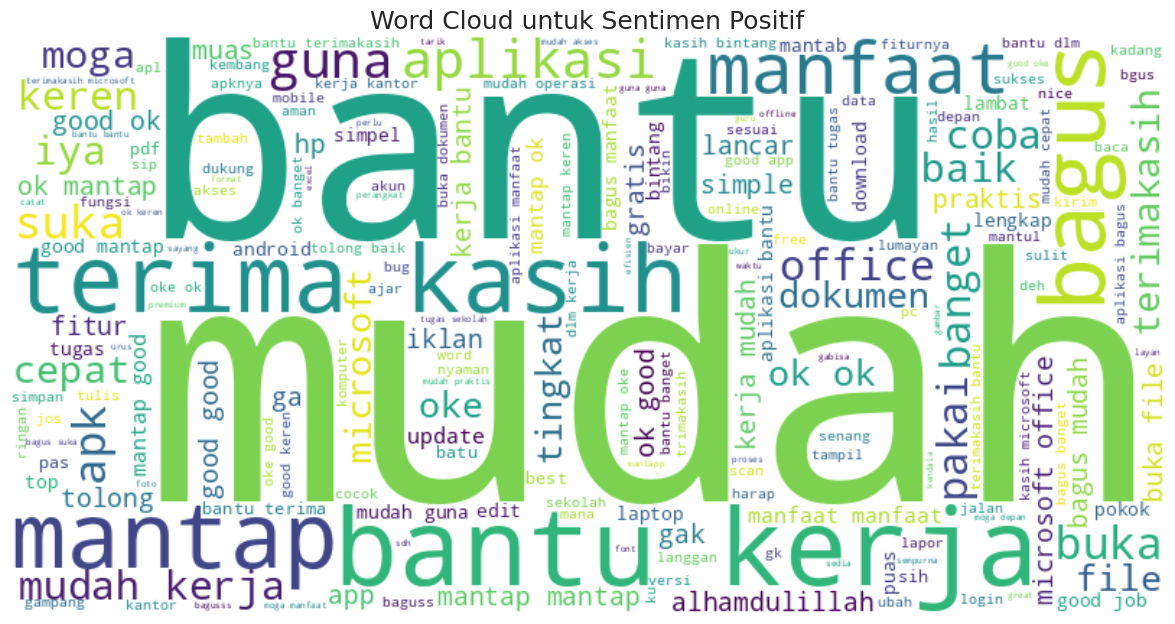

In [25]:
# Generate word cloud for positive sentiments
positive_text = ' '.join(dataset_clean[dataset_clean['sentiment'] == 'Positive']['text_processed'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud untuk Sentimen Positif')
plt.show()

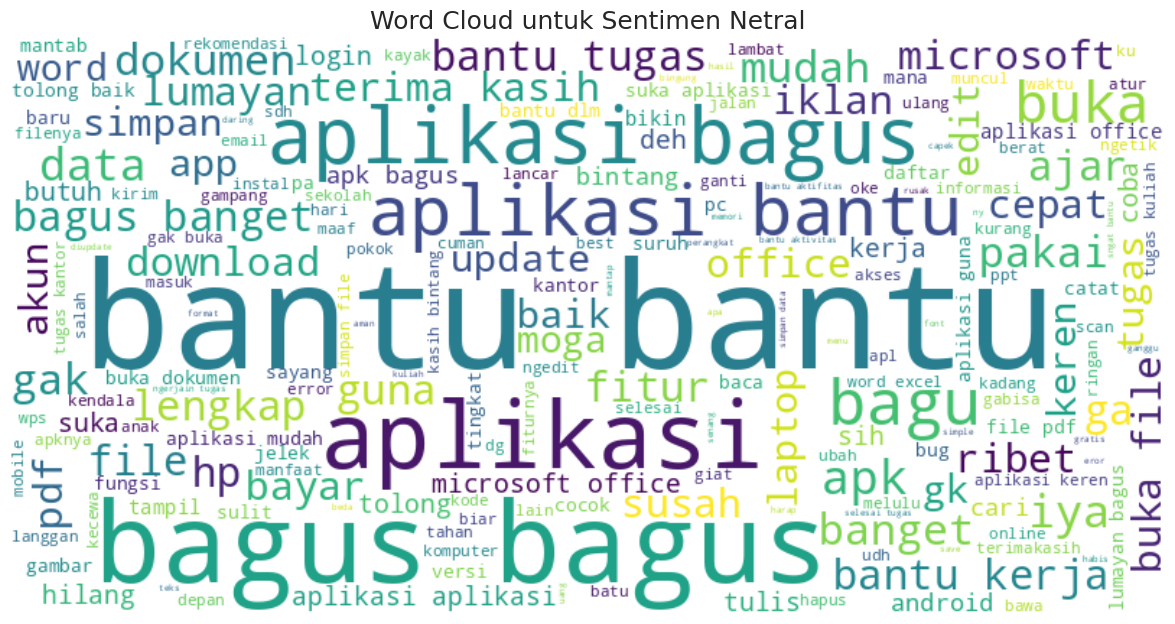

In [26]:
# Generate word cloud for neutral sentiments
neutral_text = ' '.join(dataset_clean[dataset_clean['sentiment'] == 'Neutral']['text_processed'])
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white').generate(neutral_text)

plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud untuk Sentimen Netral')
plt.show()

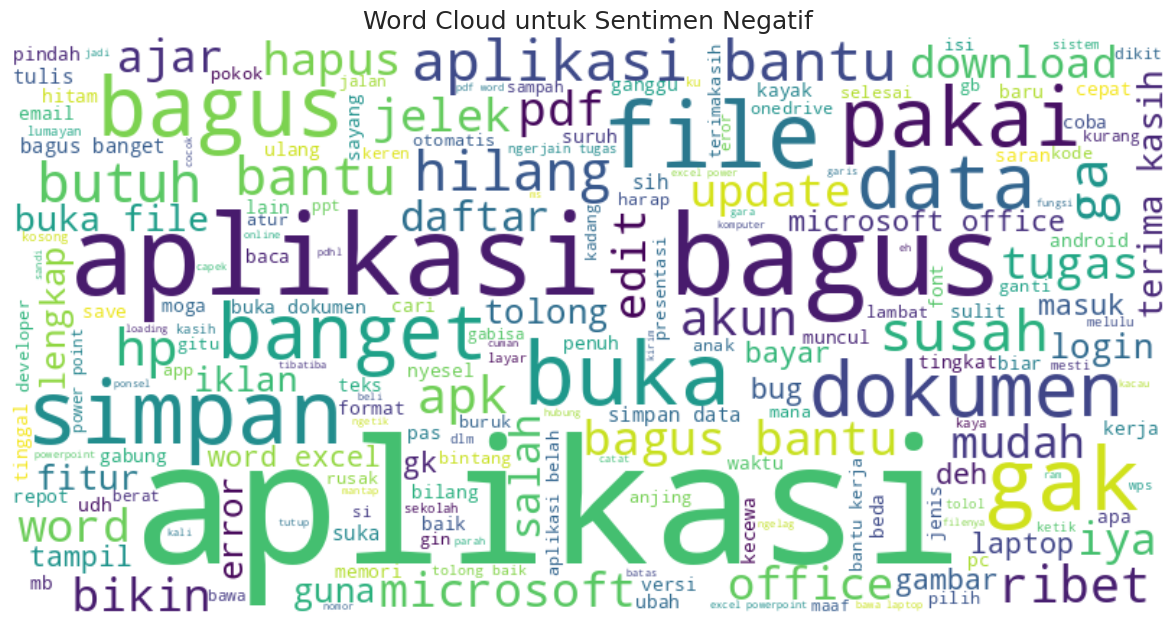

In [27]:
# Generate word cloud for negative sentiments
negative_text = ' '.join(dataset_clean[dataset_clean['sentiment'] == 'Negative']['text_processed'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud untuk Sentimen Negatif')
plt.show()

### Histogram
Membuat histogram untuk memahami distribusi data

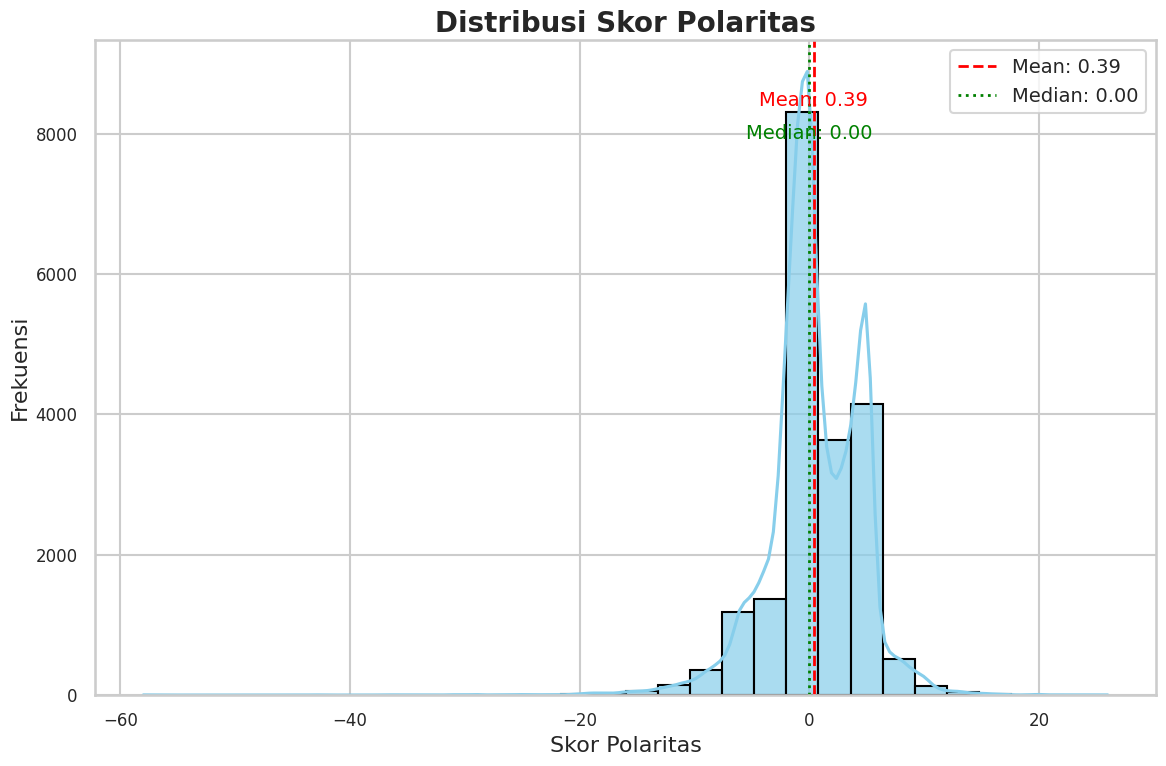

In [28]:
sns.set(style="whitegrid", context="talk")
plt.figure(figsize=(12, 8))
palette = sns.color_palette("viridis", as_cmap=True)

sns.histplot(
    dataset_clean['sentiment_score'],
    bins=30,
    kde=True,
    color='skyblue',
    edgecolor='black',
    alpha=0.7,
    linewidth=1.5,
)

mean_score = dataset_clean['sentiment_score'].mean()
median_score = dataset_clean['sentiment_score'].median()

plt.axvline(mean_score, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_score:.2f}')
plt.axvline(median_score, color='green', linestyle='dotted', linewidth=2, label=f'Median: {median_score:.2f}')

plt.title('Distribusi Skor Polaritas', fontsize=20, fontweight='bold')
plt.xlabel('Skor Polaritas', fontsize=16)
plt.ylabel('Frekuensi', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(fontsize=14)

plt.text(mean_score, plt.ylim()[1]*0.9, f'Mean: {mean_score:.2f}', color='red', fontsize=14, ha='center')
plt.text(median_score, plt.ylim()[1]*0.85, f'Median: {median_score:.2f}', color='green', fontsize=14, ha='center')

plt.tight_layout()
plt.show()

### Diagram Batang Kata yang Paling Sering Muncul

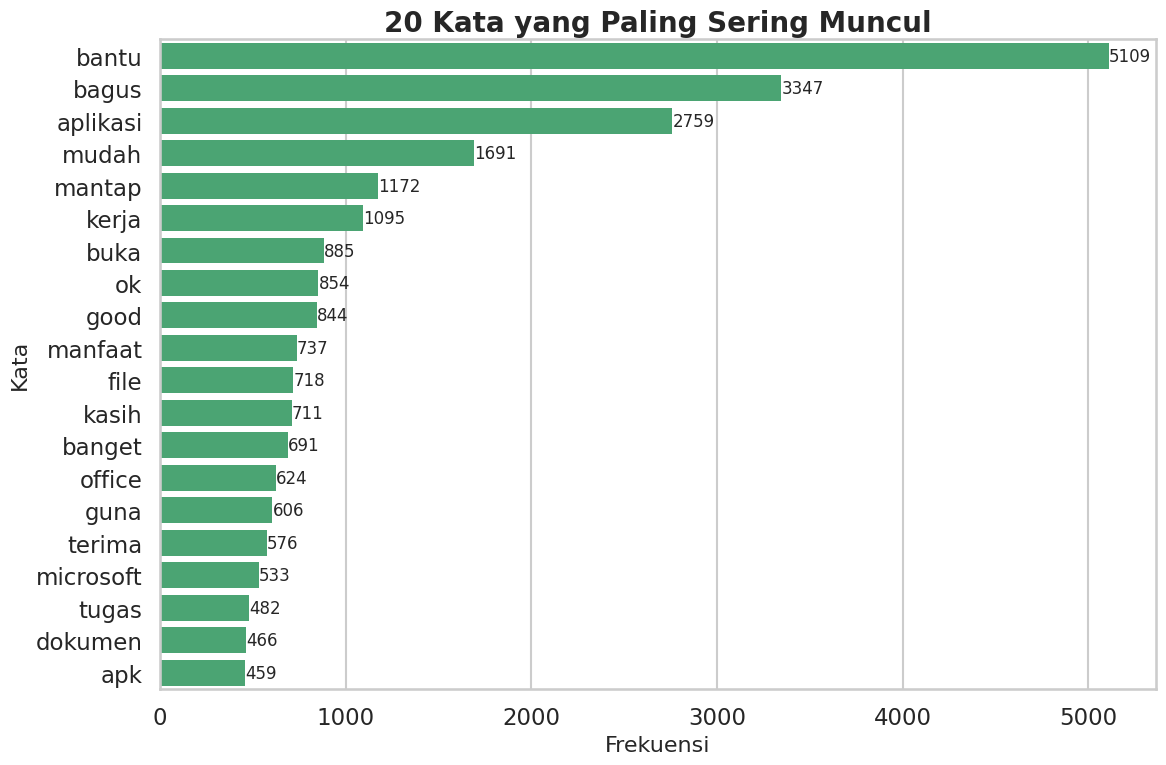

In [29]:
# Vectorize data
vectorizer = CountVectorizer()
word_counts = vectorizer.fit_transform(dataset_clean['text_processed'])
word_freq = pd.DataFrame(word_counts.toarray(), columns=vectorizer.get_feature_names_out())

word_freq_sum = word_freq.sum().reset_index()
word_freq_sum.columns = ['word', 'frequency']

top_words = word_freq_sum.sort_values(by='frequency', ascending=False).head(20)

# Plot the bar chart
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    x='frequency',
    y='word',
    data=top_words,
    color='mediumseagreen',
    edgecolor='none'
)

plt.title('20 Kata yang Paling Sering Muncul', fontsize=20, fontweight='bold')
plt.xlabel('Frekuensi', fontsize=16)
plt.ylabel('Kata', fontsize=16)

for p in ax.patches:
    width = p.get_width()
    ax.annotate(
        str(int(width)),
        (width + 0.5, p.get_y() + p.get_height() / 2),
        ha='left',
        va='center',
        fontsize=12
    )

plt.tight_layout()

plt.show()

## Modelling

**Label Encoding**

In [30]:
# Label encoding
encoder = LabelEncoder()
dataset_clean['sentiment_encoded'] = encoder.fit_transform(dataset_clean['sentiment'])

# One-hot encoding for categorical crossentropy
y_one_hot = tf.keras.utils.to_categorical(dataset_clean['sentiment_encoded'], num_classes=3)

# Display the first few rows
dataset_clean[['content', 'text_processed', 'sentiment', 'sentiment_encoded']].head()

,content,text_processed,sentiment,sentiment_encoded
0,Belakangan tidak bisa membuka pdf yg memorinya...,buka pdf memori biarpun update jaring bagus in...,Positive,2
1,"Membantu bekerja, terima kasih. Setelah pemaka...",bantu terima kasih pakai sekian sekakarang buk...,Positive,2
2,Saya membayar Office 365 basic disebutkan bisa...,bayar office basic akun device ponsel tablet t...,Neutral,1
3,Kok font times new roman di hapus padahal nih ...,font times new roman hapus tugas makalah tingg...,Negative,0
4,"Fitur bagus, tapi kekurangan tidak bisa buka d...",fitur bagus kurang buka file buka file buka fi...,Negative,0


### 1. ResNet dengan Tokenizer (80/20)


**Feature Extraction: Tokenization and Padding**

In [37]:
# Initialize Tokenizer
tokenizer_resnet = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer_resnet.fit_on_texts(dataset_clean['text_processed'])

# Convert texts to sequences
X_sequences_resnet = tokenizer_resnet.texts_to_sequences(dataset_clean['text_processed'])

# Pad the sequences
max_length_resnet = 100  # Define maximum sequence length
X_padded_resnet = pad_sequences(X_sequences_resnet, maxlen=max_length_resnet, padding='post', truncating='post')

# Define labels
y_resnet = dataset_clean['sentiment_encoded'].values

**Data splitting**

In [38]:
X_train_resnet, X_test_resnet, y_train_resnet, y_test_resnet = train_test_split(
    X_padded_resnet, y_resnet, test_size=0.2, random_state=42, stratify=y_resnet
)

**Model Building: Residual Network**

In [52]:
def residual_block(x, filters, kernel_size, padding='same'):
    shortcut = x
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding=padding, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding=padding, activation=None)(x)
    x = BatchNormalization()(x)
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

def build_resnet_model(vocab_size, embedding_dim, input_length, num_classes):
    """Builds a ResNet-like model for text classification."""
    inputs = Input(shape=(input_length,))
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length)(inputs)

    # Initial Convolution
    x = Conv1D(filters=128, kernel_size=5, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # Add Residual Blocks
    for _ in range(3):
        x = residual_block(x, filters=128, kernel_size=3)

    # Pooling
    x = GlobalMaxPooling1D()(x)

    # Dense Layers
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create Model
    model = Model(inputs=inputs, outputs=outputs)

    return model

# Define model parameters
vocab_size_resnet = 5000
embedding_dim_resnet = 128
num_classes_resnet = 3  # Negative, Neutral, Positive

# Build the model
model_resnet = build_resnet_model(vocab_size_resnet, embedding_dim_resnet, max_length_resnet, num_classes_resnet)

# Compile the model
model_resnet.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model_resnet.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 100, 128)       │        640,000 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_17 (Conv1D)        │ (None, 100, 128)       │         82,048 │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 100, 128)       │            512 │ conv1d_17[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_18 (Conv1D)        │ (None, 100, 128)       │         49,280 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 100, 128)       │            512 │ conv1d_18[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_19 (Conv1D)        │ (None, 100, 128)       │         49,280 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 100, 128)       │            512 │ conv1d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 100, 128)       │              0 │ batch_normalization_1… │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_6 (Activation) │ (None, 100, 128)       │              0 │ add_7[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_20 (Conv1D)        │ (None, 100, 128)       │         49,280 │ activation_6[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 100, 128)       │            512 │ conv1d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_21 (Conv1D)        │ (None, 100, 128)       │         49,280 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 100, 128)       │            512 │ conv1d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 100, 128)       │              0 │ activation_6[0][0],    │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_7 (Activat

 Total params: 1,025,539 (3.91 MB)

 Trainable params: 1,023,747 (3.91 MB)

 Non-trainable params: 1,792 (7.00 KB)

**Model Training**

In [53]:
# Define early stopping
early_stop_resnet = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Train the model
history_resnet = model_resnet.fit(
    X_train_resnet, y_train_resnet,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_resnet, y_test_resnet),
    callbacks=[early_stop_resnet]
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.7407 - loss: 1.1557 - val_accuracy: 0.8710 - val_loss: 0.4226
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8746 - loss: 0.3158 - val_accuracy: 0.8813 - val_loss: 0.2937
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9074 - loss: 0.2418 - val_accuracy: 0.9150 - val_loss: 0.2567
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9239 - loss: 0.1984 - val_accuracy: 0.9125 - val_loss: 0.2284
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9343 - loss: 0.1649 - val_accuracy: 0.9275 - val_loss: 0.2183
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9367 - loss: 0.1569 - val_accuracy: 0.9293 - val_loss: 0.2701
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9463 - loss: 0.1340 - val_accuracy: 0.9250 - val_loss: 0.2363
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9471 - loss: 0.1330 - val_accuracy: 0

**Model Evaluation (Test)**

In [54]:
# Evaluate the model
loss_resnet, accuracy_resnet = model_resnet.evaluate(X_test_resnet, y_test_resnet)
print(f'ResNet Model Accuracy: {accuracy_resnet * 100:.2f}%')

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9262 - loss: 0.2128
ResNet Model Accuracy: 92.75%


**Plot Training History**

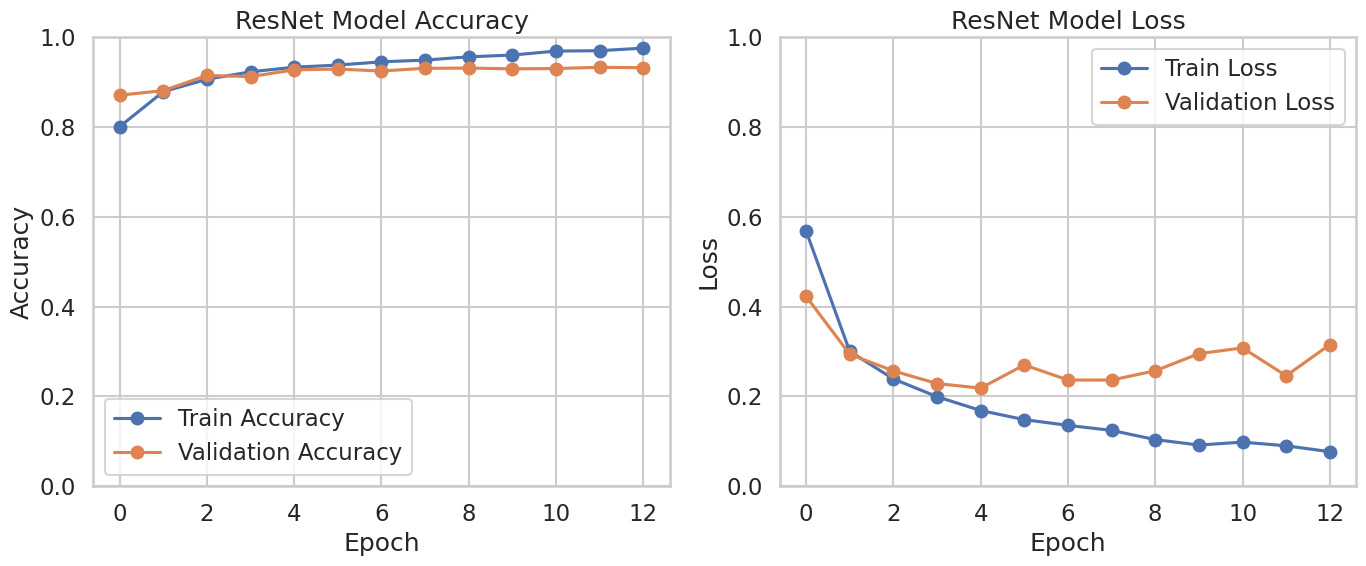

In [55]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('ResNet Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Train Loss', marker='o')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss', marker='o')
plt.title('ResNet Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 2. Bidirectional LSTM with Embedding (70/30)

**Feature Extraction: Tokenization and Embedding**

In [60]:
# Initialize Tokenizer
tokenizer_lstm = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer_lstm.fit_on_texts(dataset_clean['text_processed'])

# Convert texts to sequences
X_sequences_lstm = tokenizer_lstm.texts_to_sequences(dataset_clean['text_processed'])

# Pad the sequences
max_length_lstm = 100
X_padded_lstm = pad_sequences(X_sequences_lstm, maxlen=max_length_lstm, padding='post', truncating='post')

# Define labels
y_lstm = dataset_clean['sentiment_encoded'].values

**Data Splitting**

In [61]:
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_padded_lstm, y_lstm, test_size=0.3, random_state=42, stratify=y_lstm
)

**Model Building: Bidirectional LSTM**

In [63]:
model_lstm = Sequential([
    Embedding(input_dim=5000, output_dim=128),
    Bidirectional(LSTM(64, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
model_lstm.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model_lstm.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_6               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

**Model Training**

In [64]:
# Define early stopping
early_stop_lstm = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history_lstm = model_lstm.fit(
    X_train_lstm, y_train_lstm,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_lstm, y_test_lstm),
    callbacks=[early_stop_lstm]
)


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.7582 - loss: 0.5624 - val_accuracy: 0.9335 - val_loss: 0.1703
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9520 - loss: 0.1370 - val_accuracy: 0.9515 - val_loss: 0.1295
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9765 - loss: 0.0713 - val_accuracy: 0.9535 - val_loss: 0.1420
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9863 - loss: 0.0491 - val_accuracy: 0.9575 - val_loss: 0.1495
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9878 - loss: 0.0395 - val_accuracy: 0.9532 - val_loss: 0.1718


**Model Evaluation (Test)**

In [65]:
# Evaluate the model
loss_lstm, accuracy_lstm = model_lstm.evaluate(X_test_lstm, y_test_lstm)
print(f'Bidirectional LSTM Model Accuracy: {accuracy_lstm * 100:.2f}%')

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9480 - loss: 0.1417
Bidirectional LSTM Model Accuracy: 95.15%


**Plot Training History**

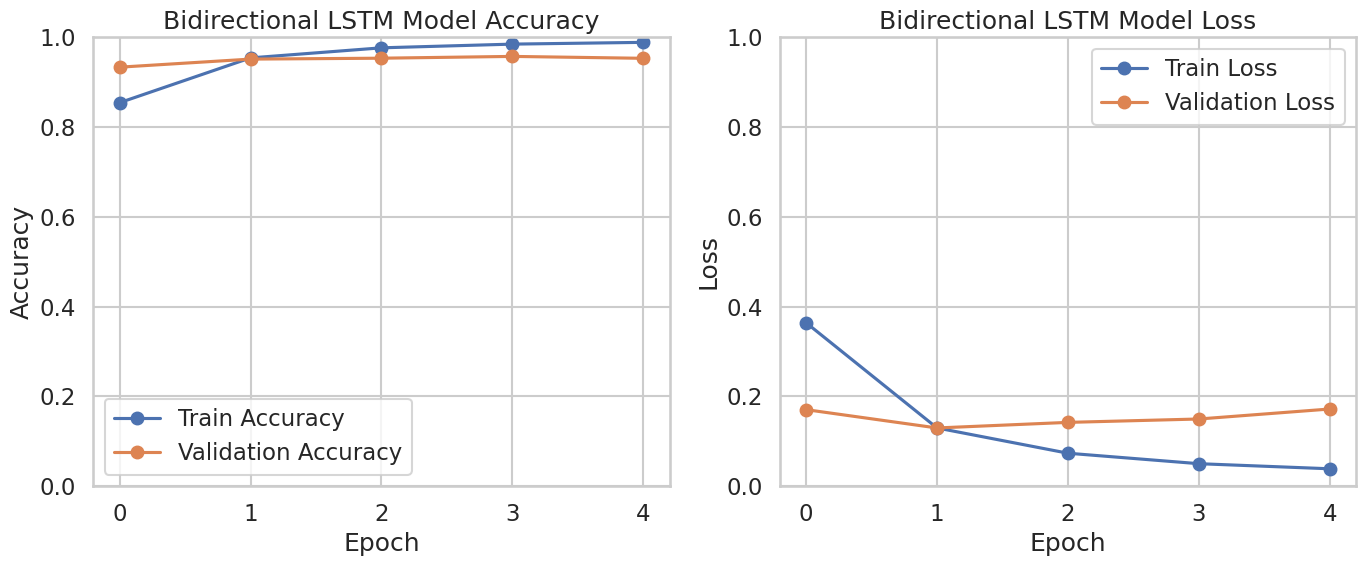

In [66]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Bidirectional LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Train Loss', marker='o')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Bidirectional LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 3. Convolutional Neural Network (CNN) with Embedding (75/25)

**Feature Extraction: Tokenization and Embedding**

In [75]:
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(
    X_padded_lstm, y_lstm, test_size=0.25, random_state=42, stratify=y_lstm
)

**Model Building: Convolutional Neural Network (CNN)**

In [76]:
# Define the CNN model
model_cnn = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_length_lstm),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Assuming 3 classes
])

# Compile the model
model_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model_cnn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_26 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_9               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

**Model Training**

In [77]:
# Define early stopping
early_stop_cnn = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history_cnn = model_cnn.fit(
    X_train_cnn, y_train_cnn,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_cnn, y_test_cnn),
    callbacks=[early_stop_cnn]
)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.7613 - loss: 0.5603 - val_accuracy: 0.9256 - val_loss: 0.1827
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9448 - loss: 0.1513 - val_accuracy: 0.9340 - val_loss: 0.1608
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9716 - loss: 0.0882 - val_accuracy: 0.9422 - val_loss: 0.1715
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9828 - loss: 0.0571 - val_accuracy: 0.9394 - val_loss: 0.2098
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9911 - loss: 0.0327 - val_accuracy: 0.9394 - val_loss: 0.2131


**Model Evaluation (Test)**

In [78]:
# Evaluate the model
loss_cnn, accuracy_cnn = model_cnn.evaluate(X_test_cnn, y_test_cnn)
print(f'CNN Model Accuracy: {accuracy_cnn * 100:.2f}%')

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9318 - loss: 0.1691
CNN Model Accuracy: 93.40%


**Plot Training History**

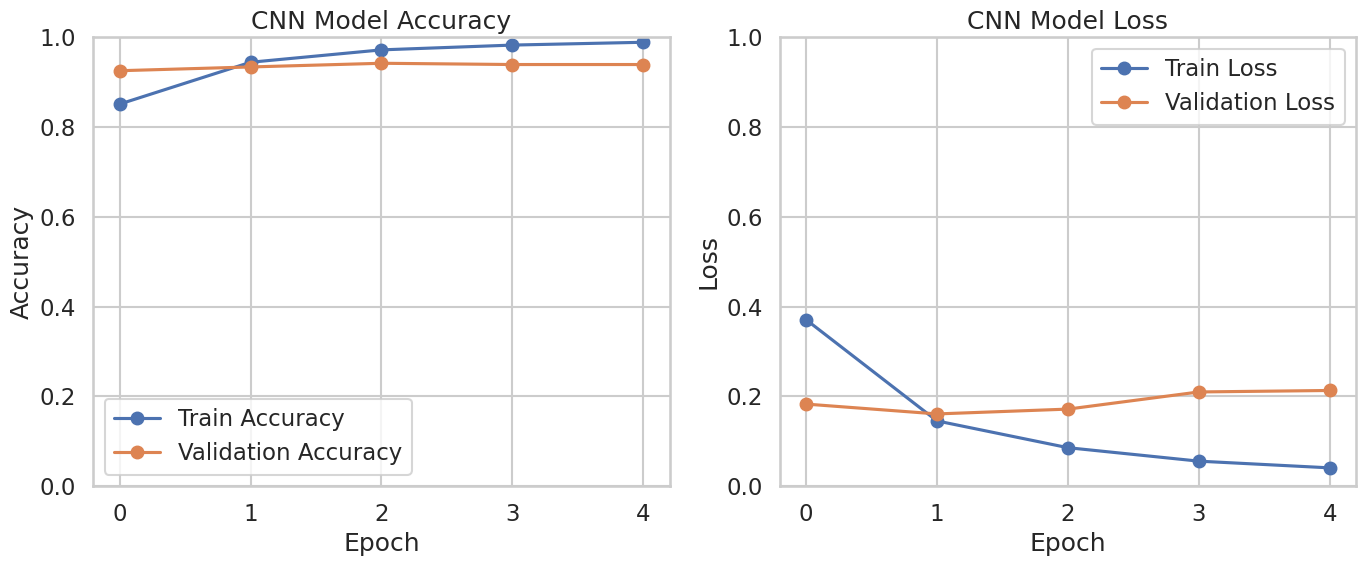

In [80]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss', marker='o')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss', marker='o')
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Evaluasi Seluruh Model

In [137]:
# Evaluate each model and store the results in a DataFrame
evaluation_results = []

# Evaluate LSTM model
loss_lstm, accuracy_lstm = model_lstm.evaluate(X_test_lstm, y_test_lstm, verbose=0)
evaluation_results.append({
    "Model": "LSTM",
    "Loss": loss_lstm,
    "Val Accuracy": accuracy_lstm
})

# Evaluate ResNet model
loss_resnet, accuracy_resnet = model_resnet.evaluate(X_test_resnet, y_test_resnet, verbose=0)
evaluation_results.append({
    "Model": "ResNet",
    "Loss": loss_resnet,
    "Val Accuracy": accuracy_resnet
})

# Evaluate CNN model
loss_cnn, accuracy_cnn = model_cnn.evaluate(X_test_cnn, y_test_cnn, verbose=0)
evaluation_results.append({
    "Model": "CNN",
    "Loss": loss_cnn,
    "Val Accuracy": accuracy_cnn
})

# Convert results to a DataFrame
evaluation_df = pd.DataFrame(evaluation_results)

# Display the evaluation results
print("Evaluation Results:")
print(evaluation_df)

Evaluation Results:
    Model      Loss  Val Accuracy
0    LSTM  0.129509        0.9515
1  ResNet  0.218318        0.9275
2     CNN  0.160781        0.9340


## Menyimpan Model

In [139]:
model_lstm.save('model_lstm.keras')
model_resnet.save('model_resnet.keras')
model_cnn.save('model_cnn.keras')

print("Semua model berhasil disimpan")

Semua model berhasil disimpan


## Fungsi Inference
Membuat fungsi untuk melakukan inferensi pada input teks baru. Fungsi ini akan memproses teks masukan terlebih dahulu, mengubahnya menjadi format yang sesuai, dan menggunakan model terlatih untuk memprediksi kelas sentimen.

In [133]:
# New text samples with manually assigned labels
sample_texts = [
    ("Mantap mantap sekali. Luar biasa. Ok.", "Positive"),
    ("Bisa untuk membuka file dari email, cukup dibutuhkan oleh semua orang", "Neutral"),
    ("Aplikasi jelek, banyak bug. Bikin kecewa", "Negative")
]

In [135]:
# Define a list to store the results for each sample text
results = []

# Perform inference on each sample text and store the results
for text, manual_label in sample_texts:
    # Prediction from LSTM model
    processed_text = preprocess_text(text)
    sequence_lstm = tokenizer_lstm.texts_to_sequences([processed_text])
    padded_sequence_lstm = pad_sequences(sequence_lstm, maxlen=max_length_lstm, padding='post', truncating='post')
    prediction_lstm = model_lstm.predict(padded_sequence_lstm)
    predicted_class_lstm = np.argmax(prediction_lstm, axis=1)[0]
    predicted_label_lstm = encoder.inverse_transform([predicted_class_lstm])[0]

    # Prediction from ResNet model
    sequence_resnet = tokenizer_resnet.texts_to_sequences([processed_text])
    padded_sequence_resnet = pad_sequences(sequence_resnet, maxlen=max_length_resnet, padding='post', truncating='post')
    prediction_resnet = model_resnet.predict(padded_sequence_resnet)
    predicted_class_resnet = np.argmax(prediction_resnet, axis=1)[0]
    predicted_label_resnet = encoder.inverse_transform([predicted_class_resnet])[0]

    # Prediction from CNN model
    sequence_cnn = tokenizer_lstm.texts_to_sequences([processed_text])
    padded_sequence_cnn = pad_sequences(sequence_cnn, maxlen=max_length_lstm, padding='post', truncating='post')
    prediction_cnn = model_cnn.predict(padded_sequence_cnn)
    predicted_class_cnn = np.argmax(prediction_cnn, axis=1)[0]
    predicted_label_cnn = encoder.inverse_transform([predicted_class_cnn])[0]

    # Append the result to the results list
    results.append({
        "Teks": text,
        "Manual Label": manual_label,
        "Prediksi (ResNet)": predicted_label_resnet,
        "Prediksi (LSTM)": predicted_label_lstm,
        "Prediksi (CNN)": predicted_label_cnn
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results in table form
results_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


,Teks,Manual Label,Prediksi (ResNet),Prediksi (LSTM),Prediksi (CNN)
0,Mantap mantap sekali. Luar biasa. Ok.,Positive,Positive,Positive,Positive
1,"Bisa untuk membuka file dari email, cukup dibu...",Neutral,Neutral,Neutral,Neutral
2,"Aplikasi jelek, banyak bug. Bikin kecewa",Negative,Negative,Negative,Negative
